# Assignment 4 
## Network Measurements and Analysis of the Tor Network Using Open Data

## Introduction

The Tor ("The Onion Router") network is a decentralized network which allows users to browse the internet anonymously and privately. This is achieved by routing user-traffic through a set of tor-relays, combined with en- and decryption along every point of the way, referred to as onion routing. A concrete set of relays is called a circuit, mostly consisting of one entry (or "Guard") -relay, one middle-relay and the exit-relay [1]. The exit relay, being the final relay in a circuit, is the one that sends out the traffic to its destination [2]. Exit-relays are essential for the functionality of the system, yet they also pose the biggest risk and attack surface to the privacy and anonymity goals of the users. This is why, they have been targets of attacks in the past [3]. But what if, the traffic never has to leave the tor-network? To provide increased privacy and anonymity for the client, but also to provide responder anonymity, clients can also arrange "rendezvous" inside the tor-network or make use of the so called "onion or hidden services" [1]. Onion services provide [4]:
- Location hiding for client and responder
- End-to-end authentication
- End-to-end encryption
- NAT punching

additionally to the traffic never exiting the tor-network in the first place. These onion services are what this assignement is mostly about, its trying to answer the question:

__What is the cost of this increased privacy? How do page load times on tor onion services compare to their clear web counterparts?__


## Data Collection, Measurements and Processing

For the purpose of this assignment and specifically to be able to compare onion services to their clear web counterparts, I needed to find a selection of services that exist inside the tor-network and also in the regular internet. After doing some initial research I didn't find any fitting databases or directories that could offer what i was looking for, so I had to scrape the web for these services manually. My initial approach was to look at the most popular onion services first, but that turned out to be an uncomfortable approach and also not very effective. After some more research I found out about [5] this section of the official tor blog, documenting the possibility for regular websites to advertise their onion-service counterpart in a HTTP-response headers, a field called "Onion-Location". I then downloaded the latest version of the latest tranco-list for the top one million most popular domains [6] and scraped the top 20.000 domains for their "Onion-Location". For this I used the following script:

In [ ]:
import requests
import csv

INPUT_CSV = "tranco_daily_top20k.csv"
OUTPUT_CSV = "onion_locations_found_complete.csv"
TIMEOUT = 10

def get_onion_header(domain):
    url = f"https://{domain.strip()}"
    try:
        response = requests.get(url, timeout=TIMEOUT, allow_redirects=True)
        onion_url = response.headers.get("Onion-Location")
        if onion_url and ".onion" in onion_url:
            return onion_url
    except Exception as e:
        print(f"[!] Error checking {url}: {e}")
    return None

def main():
    with open(INPUT_CSV, "r", encoding="utf-8") as infile, \
         open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as outfile:
        
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        writer.writerow(["Clear Web Domain", "Onion Address"])
        
        for row in reader:
            domain = row[1].strip()
            if not domain:
                continue
            print(f"Checking {domain}")
            onion = get_onion_header(domain)
            if onion:
                print(f"{domain} → {onion}")
                writer.writerow([domain, onion])
            else:
                print(f"No Onion header for {domain}")

if __name__ == "__main__":
    main()


This script found 26 domains, which were available in the regular internet but also advertised an onion adress: 

| Clear Web Domain     | Onion Address                                                                                      |
|----------------------|----------------------------------------------------------------------------------------------------|
| archive.org          | [https://archivep75mbjunhxc6x4j5mwjmomyxb573v42baldlqu56ruil2oiad.onion/](https://archivep75mbjunhxc6x4j5mwjmomyxb573v42baldlqu56ruil2oiad.onion/) |
| theguardian.com      | [https://www.guardian2zotagl6tmjucg3lrhxdk4dw3lhbqnkvvkywawy3oqfoprid.onion/europe](https://www.guardian2zotagl6tmjucg3lrhxdk4dw3lhbqnkvvkywawy3oqfoprid.onion/europe) |
| brave.com            | [https://brave4u7jddbv7cyviptqjc7jusxh72uik7zt6adtckl5f4nwy2v72qd.onion/index.html](https://brave4u7jddbv7cyviptqjc7jusxh72uik7zt6adtckl5f4nwy2v72qd.onion/index.html) |
| dw.com               | [https://www.dwnewsgngmhlplxy6o2twtfgjnrnjxbegbwqx6wnotdhkzt562tszfid.onion/](https://www.dwnewsgngmhlplxy6o2twtfgjnrnjxbegbwqx6wnotdhkzt562tszfid.onion/) |
| guardian.co.uk       | [https://www.guardian2zotagl6tmjucg3lrhxdk4dw3lhbqnkvvkywawy3oqfoprid.onion/europe](https://www.guardian2zotagl6tmjucg3lrhxdk4dw3lhbqnkvvkywawy3oqfoprid.onion/europe) |
| voanews.com          | [https://www.voanews5aitmne6gs2btokcacixclgfl43cv27sirgbauyyjylwpdtqd.onion/](https://www.voanews5aitmne6gs2btokcacixclgfl43cv27sirgbauyyjylwpdtqd.onion/) |
| proton.me            | [https://protonmailrmez3lotccipshtkleegetolb73fuirgj7r4o4vfu7ozyd.onion/](https://protonmailrmez3lotccipshtkleegetolb73fuirgj7r4o4vfu7ozyd.onion/) |
| amnesty.org          | [https://www.amnestyl337aduwuvpf57irfl54ggtnuera45ygcxzuftwxjvvmpuzqd.onion](https://www.amnestyl337aduwuvpf57irfl54ggtnuera45ygcxzuftwxjvvmpuzqd.onion) |
| propublica.org       | [http://p53lf57qovyuvwsc6xnrppyply3vtqm7l6pcobkmyqsiofyeznfu5uqd.onion/](http://p53lf57qovyuvwsc6xnrppyply3vtqm7l6pcobkmyqsiofyeznfu5uqd.onion/) |
| torproject.org       | [http://2gzyxa5ihm7nsggfxnu52rck2vv4rvmdlkiu3zzui5du4xyclen53wid.onion/index.html](http://2gzyxa5ihm7nsggfxnu52rck2vv4rvmdlkiu3zzui5du4xyclen53wid.onion/index.html) |
| 1337x.to             | [http://l337xdarkkaqfwzntnfk5bmoaroivtl6xsbatabvlb52umg6v3ch44yd.onion/](http://l337xdarkkaqfwzntnfk5bmoaroivtl6xsbatabvlb52umg6v3ch44yd.onion/) |
| archive.is           | [http://archiveiya74codqgiixo33q62qlrqtkgmcitqx5u2oeqnmn5bpcbiyd.onion/](http://archiveiya74codqgiixo33q62qlrqtkgmcitqx5u2oeqnmn5bpcbiyd.onion/) |
| rferl.org            | [https://www.rferlo2zxgv23tct66v45s5mecftol5vod3hf4rqbipfp46fqu2q56ad.onion/](https://www.rferlo2zxgv23tct66v45s5mecftol5vod3hf4rqbipfp46fqu2q56ad.onion/) |
| mullvad.net          | [http://o54hon2e2vj6c7m3aqqu6uyece65by3vgoxxhlqlsvkmacw6a7m7kiad.onion/en](http://o54hon2e2vj6c7m3aqqu6uyece65by3vgoxxhlqlsvkmacw6a7m7kiad.onion/en) |
| archive.ph           | [http://archiveiya74codqgiixo33q62qlrqtkgmcitqx5u2oeqnmn5bpcbiyd.onion/](http://archiveiya74codqgiixo33q62qlrqtkgmcitqx5u2oeqnmn5bpcbiyd.onion/) |
| mempool.space        | [http://mempoolhqx4isw62xs7abwphsq7ldayuidyx2v2oethdhhj6mlo2r6ad.onion/](http://mempoolhqx4isw62xs7abwphsq7ldayuidyx2v2oethdhhj6mlo2r6ad.onion/) |
| taz.de               | [http://zervmwoc5flabhlh3heegnspbpoebbgr3kgkaarkpnz2gtsuunlxgqyd.onion/!p4608;web/](http://zervmwoc5flabhlh3heegnspbpoebbgr3kgkaarkpnz2gtsuunlxgqyd.onion/!p4608;web/) |
| marxists.org         | [http://www.marxists3va6eopxoeiegih3iyex2zg3tmace7afbxjqlabmranzjjad.onion/index.htm](http://www.marxists3va6eopxoeiegih3iyex2zg3tmace7afbxjqlabmranzjjad.onion/index.htm) |
| wiz.biz              | [http://wizbizrnszzzyfe6j75tpwd7hn4gf2tlvzdsokkosxfbox73ctzaqdqd.onion/](http://wizbizrnszzzyfe6j75tpwd7hn4gf2tlvzdsokkosxfbox73ctzaqdqd.onion/) |
| f-droid.org          | [http://fdroidorg6cooksyluodepej4erfctzk7rrjpjbbr6wx24jh3lqyfwyd.onion/index.html.en](http://fdroidorg6cooksyluodepej4erfctzk7rrjpjbbr6wx24jh3lqyfwyd.onion/index.html.en) |
| cock.li              | [http://rurcblzhmdk22kttfkel2zduhyu3r6to7knyc7wiorzrx5gw4c3lftad.onion/](http://rurcblzhmdk22kttfkel2zduhyu3r6to7knyc7wiorzrx5gw4c3lftad.onion/) |
| mediapart.fr         | [https://www.mediapartrvj4bsgolbxixw57ru7fh4jqckparke4vs365guu6ho64yd.onion/](https://www.mediapartrvj4bsgolbxixw57ru7fh4jqckparke4vs365guu6ho64yd.onion/) |
| z-library.sk         | [http://bookszlibb74ugqojhzhg2a63w5i2atv5bqarulgczawnbmsb6s6qead.onion/](http://bookszlibb74ugqojhzhg2a63w5i2atv5bqarulgczawnbmsb6s6qead.onion/) |
| riseup.net           | [http://vww6ybal4bd7szmgncyruucpgfkqahzddi37ktceo3ah7ngmcopnpyyd.onion/index.en.html](http://vww6ybal4bd7szmgncyruucpgfkqahzddi37ktceo3ah7ngmcopnpyyd.onion/index.en.html) |
| blockstream.info     | [http://explorerzydxu5ecjrkwceayqybizmpjjznk5izmitf2modhcusuqlid.onion/](http://explorerzydxu5ecjrkwceayqybizmpjjznk5izmitf2modhcusuqlid.onion/) |
| svoboda.org          | [https://www.svobod7mjzb3hwxhgcnx7ui2ffd4p5zulftzkzdlmpaztuuoxnlpwhyd.onion/](https://www.svobod7mjzb3hwxhgcnx7ui2ffd4p5zulftzkzdlmpaztuuoxnlpwhyd.onion/) |


This represents approximately __0.13%__ of clearnet domains also offering a corresponding .onion address—roughly one in every 770 domains, based on the sample set I examined. For further analysis, I utilized the open-source framework Selenium [7] for automating browser interactions and data collection, alongside Stem [8], a Python controller library designed for managing Tor processes and integrating with the Tor Browser. Each domain identified in the earlier phase was accessed once through a regular browser on the clearnet, and once via the Tor network using its associated .onion address. Accessing each domain in the clearnet and its .onion counterpart once is considered a single run. To reduce potential noise and help to achieve more realistic measurements I conducted a total of 20 runs per domain, saving the results of each. Measurement consistency on the Tor network can be challenging due to its inherent design. In particular the choice of relays, or specifically the circuit, can influence the results of the measurements, which is also why it seemed beneficial to conduct multiple runs of each domain. To capture information on which relays and circuit were used for each request, the Stem library controller was used, supplemented by some additional post-processing work following the measurements. For more detailed information about the procedure, please refer to the following commented source code:

In [ ]:
import csv
import time
import logging
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from stem.control import Controller
from stem import StreamStatus
from urllib.parse import urlparse
import requests

INPUT_CSV = "onion_locations_found_filtered.csv"
OUTPUT_CSV = "onion_vs_clearnet_comparison_with_relays.csv"
NUM_RUNS = 20
DELAY_BETWEEN_RUNS = 60  

# Set up logging
logging.basicConfig(
    filename='performance_measurements.log',
    filemode='a',
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO
)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('[%(asctime)s] %(levelname)s: %(message)s', datefmt='%H:%M:%S')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)


def get_tor_controller():
    try:
        # Changed to default control port 9051
        controller = Controller.from_port(port=9151)
        controller.authenticate()  # Add password if set in torrc
        logging.info("Successfully connected to Tor controller")
        return controller
    except Exception as e:
        logging.error(f"Failed to connect to Tor controller: {e}")
        return None


def get_circuit_relays(controller, circuit_id):
    try:
        circuit = controller.get_circuit(circuit_id)
        if circuit:
            relays_info = []
            for entry in circuit.path:
                fingerprint, nickname = entry  # unpack tuple
                ip = None
                country = "Unknown"
                try:
                    ns = controller.get_network_status(fingerprint)
                    if ns:
                        ip = getattr(ns, 'address', None)  # safer access
                        if ip:
                            country = get_country_online(ip)
                except Exception as e:
                    logging.warning(f"Failed to get IP/country for {fingerprint}: {e}")
                relays_info.append((fingerprint, nickname, ip, country))
            return relays_info
    except Exception as e:
        logging.error(f"Error getting circuit relays for {circuit_id}: {e}")
    return []


def get_circuit_for_stream(controller, target_url, retries=5, delay=0.5):
    parsed = urlparse(target_url)
    hostname = parsed.hostname.replace("www.", "") if parsed.hostname else None

    for attempt in range(1, retries + 1):
        streams = controller.get_streams()
        logging.info(f"Attempt {attempt}/{retries}: Checking {len(streams)} streams for hostname '{hostname}'")

        for stream in streams:
            stream_info = (f"Stream ID: {stream.id}, Status: {stream.status}, "
                           f"Target: {stream.target}, Circuit ID: {stream.circ_id}")
            logging.debug(stream_info)

            if stream.status in [StreamStatus.NEW, StreamStatus.SUCCEEDED] and stream.target:
                stream_host = stream.target.split(':')[0].replace("www.", "")
                if stream_host == hostname:
                    logging.info(f"Matched stream {stream.id} with circuit ID {stream.circ_id}")
                    return stream.circ_id

        logging.info(f"No matching stream found on attempt {attempt}, retrying after {delay}s...")
        time.sleep(delay)

    logging.warning(f"Could not find circuit ID for {target_url} after {retries} attempts")
    return None


def get_tor_driver():
    options = Options()
    options.set_preference("network.proxy.type", 1)
    options.set_preference("network.proxy.socks", "127.0.0.1")
    options.set_preference("network.proxy.socks_port", 9150)
    options.set_preference("network.proxy.socks_version", 5)
    options.set_preference("network.proxy.socks_remote_dns", True)
    options.headless = True
    return webdriver.Firefox(options=options)


def get_clear_driver():
    options = Options()
    options.headless = True
    return webdriver.Firefox(options=options)


def measure_timings(driver, url):
    try:
        driver.get(url)
        time.sleep(5)  # Wait to allow stream registration
        timing = driver.execute_script("return window.performance.timing")

        get = lambda key: timing.get(key, 0)
        navigation_start = get("navigationStart")
        domain_lookup = get("domainLookupEnd") - get("domainLookupStart")
        connect = get("connectEnd") - get("connectStart")
        tls = get("requestStart") - get("connectEnd") if "https" in url else None
        dom = get("domContentLoadedEventEnd") - navigation_start
        page_load = get("loadEventEnd") - navigation_start
        total = get("loadEventEnd") - navigation_start

        return {
            "dns": domain_lookup if domain_lookup >= 0 else None,
            "tcp": connect if connect >= 0 else None,
            "tls": tls if tls and tls >= 0 else None,
            "dom": dom if dom >= 0 else None,
            "page_load": page_load if page_load >= 0 else None,
            "total_time": total if total >= 0 else None
        }

    except Exception as e:
        logging.warning(f"Error measuring {url}: {e}")
        return None


def clean_url(url):
    return url.strip().split("#")[0].split("?")[0]


def write_raw_data_to_csv(data_rows, mode="a"):
    """Write raw timing and circuit data rows to CSV."""
    with open(OUTPUT_CSV, mode, newline="", encoding="utf-8") as outfile:
        writer = csv.writer(outfile)
        if mode == "w":
            writer.writerow([
                "Clear Domain", "Type", "URL",
                "DNS Lookup (ms)", "TCP Connect (ms)", "TLS Handshake (ms)",
                "DOMContentLoaded (ms)", "Page Load (ms)", "Total Time (ms)",
                "Circuit Relays (Onion only)"
            ])
        for row in data_rows:
            writer.writerow(row)


def get_country_online(ip):
    try:
        response = requests.get(f"https://ipinfo.io/{ip}/json", timeout=2)
        if response.status_code == 200:
            data = response.json()
            return data.get("country", "Unknown")
    except Exception:
        pass
    return "Unknown"


def main():
    controller = get_tor_controller()
    if not controller:
        logging.warning("Tor controller not available, relay info will not be logged.")

    with open(INPUT_CSV, "r", encoding="utf-8") as infile:
        reader = list(csv.DictReader(infile))

    # Open output file once, write header
    with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as outfile:
        writer = csv.writer(outfile)
        writer.writerow([
            "Clear Domain", "Type", "URL",
            "DNS Lookup (ms)", "TCP Connect (ms)", "TLS Handshake (ms)",
            "DOMContentLoaded (ms)", "Page Load (ms)", "Total Time (ms)",
            "Circuit Relays (Onion only)"
        ])

        for run in range(1, NUM_RUNS + 1):
            logging.info(f"Starting measurement run {run} of {NUM_RUNS}")

            for row in reader:
                clear_domain = row["Clear Web Domain"]
                onion_url = clean_url(row["Onion Address"])
                clear_url = f"https://{clear_domain}"

                # Measure onion
                try:
                    logging.info(f"Measuring ONION for {clear_domain}")
                    tor_driver = get_tor_driver()
                    onion_metrics = measure_timings(tor_driver, onion_url)

                    circuit_relays_str = ""
                    if onion_metrics:
                        if controller:
                            circuit_id = get_circuit_for_stream(controller, onion_url)
                            if circuit_id:
                                circuit_relays = get_circuit_relays(controller, circuit_id)
                                if circuit_relays:
                                    circuit_relays_str = "; ".join([
                                        f"{fp}:{nick}:{ip if ip else 'Unknown'}:{country}"
                                        for fp, nick, ip, country in circuit_relays
                                    ])
                                logging.info(f"Circuit used for {onion_url}: {circuit_relays_str}")
                            else:
                                logging.warning(f"Could not find circuit ID for {onion_url}")

                        writer.writerow([
                            clear_domain, "onion", onion_url,
                            onion_metrics["dns"], onion_metrics["tcp"], onion_metrics["tls"],
                            onion_metrics["dom"], onion_metrics["page_load"], onion_metrics["total_time"],
                            circuit_relays_str
                        ])
                        outfile.flush()
                    tor_driver.quit()
                except Exception as e:
                    logging.error(f"Error during ONION measurement for {clear_domain}: {e}")

                # Measure clear web
                try:
                    logging.info(f"Measuring CLEAR WEB for {clear_domain}")
                    clear_driver = get_clear_driver()
                    clear_metrics = measure_timings(clear_driver, clear_url)
                    if clear_metrics:
                        writer.writerow([
                            clear_domain, "clear", clear_url,
                            clear_metrics["dns"], clear_metrics["tcp"], clear_metrics["tls"],
                            clear_metrics["dom"], clear_metrics["page_load"], clear_metrics["total_time"],
                            ""  # no circuit info for clear web
                        ])
                        outfile.flush()
                    clear_driver.quit()
                except Exception as e:
                    logging.error(f"Error during CLEAR WEB measurement for {clear_domain}: {e}")

            if run < NUM_RUNS:
                logging.info(f"Waiting {DELAY_BETWEEN_RUNS}s before next run")
                time.sleep(DELAY_BETWEEN_RUNS)

    logging.info("All runs completed.")


if __name__ == "__main__":
    main()


Its worth noting that the set of domains used for the measurements was slightly smaller than the original one, because some domains were avoided due to legality and safety concerns. 

The resulting measurements were structured like shown in this sample (simplified for improved readability):

### Tor vs Clearnet Access Measurements (Simplified)

| Domain         | Type   | URL                                                                                                         | DNS (ms) | TCP (ms) | DOMContentLoaded (ms) | Page Load (ms) | Circuit Relays (Onion only) |
|----------------|--------|-------------------------------------------------------------------------------------------------------------|----------|----------|------------------------|----------------|------------------------------|
| archive.org     | onion  | `https://archivep75mb...onion/`                                                                            | 0        | 2822     | 4893                   | 10009          | `prsv:194.26.192.186:NL; FragiGrenade:88.99.144.235:DE; scaletor:212.47.229.2:FR` |
| archive.org     | clear  | `https://archive.org`                                                                                       | 14       | 412      | 1270                   | 1838           | –                            |
| theguardian.com | onion  | `https://www.guardian2zot...onion/europe`                                                                   | 0        | 18169    | 19897                  | 37745          | `EchoOfTruth:213.165.81.97:ES; FragiGrenade:88.99.144.235:DE; acehoodbroward:64.65.63.40:NL` |
| theguardian.com | clear  | `https://theguardian.com`                                                                                   | 0        | 0        | 382                    | 499            | –                            |
| brave.com       | onion  | `https://brave4u7jddb...onion/index.html`                                                                   | 0        | 0        | 9381                   | 12451          | `EchoOfTruth:213.165.81.97:ES; FragiGrenade:88.99.144.235:DE; pewpew:188.245.203.234:DE` |
| brave.com       | clear  | `https://brave.com`                                                                                         | 32       | 44       | 335                    | 397            | –                            |
| voanews.com     | onion  | `https://www.voanews5ait...onion/`                                                                          | 0        | 2348     | 4436                   | 8480           | `prsv:194.26.192.186:NL; cuptor01:45.136.28.24:DE; fuchs5:65.21.94.13:FI` |
| voanews.com     | clear  | `https://voanews.com`                                                                                       | 29       | 17       | 300                    | 1208           | –                            |


The "Circuit Relays"-column denotes the full circuit used for each request, with the corresponding nickname, IP-adress and country for each relay in the circuit. In the context of onion services its worth mentioning that the last relay in each circuit is not an "exit-relay" anymore, but rather a shared rendezvous point that is reached by the client and the service, inside the network.
The full results of these measurements can be accessed in a csv in this project-directory (onion_vs_clearnet_comparison_with_relays.csv).

## Interpretation and Reporting

### Setup and loading the dataframe

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go

# Load CSV data
df = pd.read_csv('onion_vs_clearnet_comparison_with_relays.csv')

With the measurements from the previous step completed, let's move on to evaluating and analyzing the data. We'll start by focusing on the most interesting insights, as well as some "low-hanging fruit": comparing the average onion loading times against their clear web counterparts. This comparison will help us quickly identify how well the onion services perform.

                  Avg Clear Web Load Time (ms)  Avg Onion Load Time (ms)  Slowdown Factor
Clear Domain                                                                             
theguardian.com                         441.70                 19,263.20            43.61
brave.com                               369.20                 10,228.80            27.71
amnesty.org                             817.00                 10,063.90            12.32
f-droid.org                             509.15                  5,315.25            10.44
mullvad.net                             636.45                  6,038.90             9.49
taz.de                                  623.60                  5,792.25             9.29
svoboda.org                           1,304.25                 11,655.20             8.94
cock.li                                 260.00                  2,279.70             8.77
mediapart.fr                            491.90                  4,005.70             8.14
proton.me 

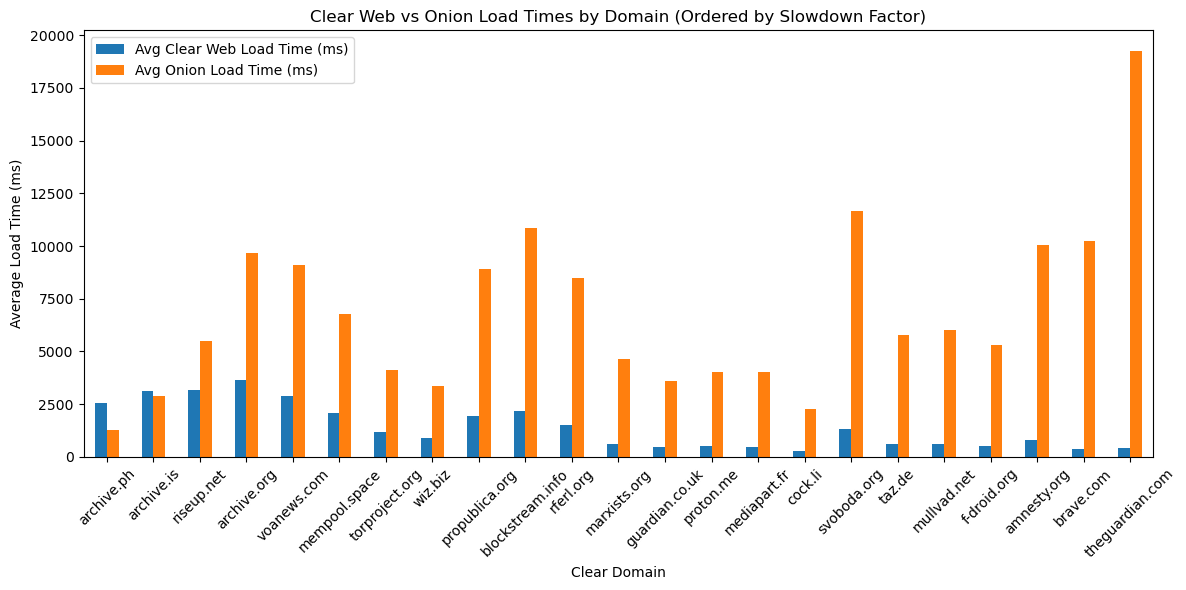

In [31]:
# Filter types
onion_df = df[df['Type'] == 'onion']
clear_df = df[df['Type'] == 'clear']

# Average total load times per domain
avg_onion = onion_df.groupby('Clear Domain')['Total Time (ms)'].mean()
avg_clear = clear_df.groupby('Clear Domain')['Total Time (ms)'].mean()

# Combine both averages
summary = pd.DataFrame({
    'Avg Clear Web Load Time (ms)': avg_clear,
    'Avg Onion Load Time (ms)': avg_onion
})

# Calculate slowdown factor
summary['Slowdown Factor'] = summary['Avg Onion Load Time (ms)'] / summary['Avg Clear Web Load Time (ms)']

# Drop NaNs if any (in case a domain is only in one set)
summary = summary.dropna()

# Print summary table
print(summary.sort_values(by='Slowdown Factor', ascending=False).to_string(float_format='{:,.2f}'.format))

average_slowdown = summary["Slowdown Factor"].mean()
print(f"Average Slowdown Factor: {average_slowdown:.2f}")

summary_sorted = summary.sort_values('Slowdown Factor', ascending=True)

summary_sorted.plot(
    kind='bar',
    y=['Avg Clear Web Load Time (ms)', 'Avg Onion Load Time (ms)'],
    figsize=(12, 6),
    title='Clear Web vs Onion Load Times by Domain (Ordered by Slowdown Factor)',
    rot=45
)

plt.ylabel('Average Load Time (ms)')
plt.tight_layout()
plt.show()



As we can see in the table and graphic above, accessing the services on the tor network is significantly slower than on their clear web counterparts. This was defenitely the expected outcome, but whats interesting in particular is the extend to what it is true, at least for some of the services. Averaging the slowdown-factor for every domain, it takes about 8.5 times as long to access the .onion counterparts, leading to multiple seconds of waiting time, for the slower domains even upwards of 10 seconds. Its important to keep in mind with these results though, that they have already been averaged over 20 different accesses, so depending on your circuit configuration you can expect loading times much worse than what is shown here. But how much does your dynamically chosen circuit really impact the loading times when using hidden services? For this I thought it might be interesting to also look at the standard deviation of loading times for each domain, additionally to the coefficient of variation, which gives insight into the relative variability of the measurement, without relying on absolute numbers (coefficient closer to 1 means there are big deviations in the measurements):

In [6]:
# Filter only .onion rows
onion_df = df[df['Type'] == 'onion']

# Group by 'Clear Domain' and calculate mean, std deviation
grouped = onion_df.groupby('Clear Domain')['Page Load (ms)'].agg(['mean', 'std'])

# Calculate Coefficient of Variation (cv = std / mean)
grouped['Coefficient of Variation'] = grouped['std'] / grouped['mean']

# Rename columns with full descriptive names
grouped = grouped.rename(columns={
    'mean': 'Avg Onion Load Time (ms)',
    'std': 'Standard Deviation (ms)'
})

# Reset index and rename index column to "Clear domain name"
grouped = grouped.reset_index().rename(columns={'Clear Domain': 'Clear domain name'})

# Sort descending by Avg Onion Load Time (ms)
grouped = grouped.sort_values(by='Avg Onion Load Time (ms)', ascending=False)

# Optional: round values for better readability
grouped = grouped.round({
    'Avg Onion Load Time (ms)': 2,
    'Standard Deviation (ms)': 2,
    'Coefficient of Variation': 3
})

# Print without the DataFrame index
print(grouped.to_string(index=False))



Clear domain name  Avg Onion Load Time (ms)  Standard Deviation (ms)  Coefficient of Variation
  theguardian.com                  19263.20                 12510.33                     0.649
      svoboda.org                  11655.20                  9398.38                     0.806
 blockstream.info                  10865.35                  2348.25                     0.216
        brave.com                  10228.80                  1585.50                     0.155
      amnesty.org                  10063.90                  4591.49                     0.456
      archive.org                   9649.15                  1808.16                     0.187
      voanews.com                   9088.15                  1624.20                     0.179
   propublica.org                   8892.15                  2666.95                     0.300
        rferl.org                   8465.45                  1783.66                     0.211
    mempool.space                   6763.55       

As we've observed, loading times can vary significantly. A coefficient of variation around 0.3 might be acceptable for services with consistently fast load times-for instance, when a service typically loads in about 600 ms, a fluctuation of ±200 ms is relatively small. However, for services where average load times approach 5 to 10 seconds, these variations can translate into very substantial delays, leading to a pretty bad user experience.

One of the reoccuring outliers in these measurements is the archive.ph domain, aswell as archive.is to some extend, which both somehow manage to provide faster loading times for their onion service variant, than their clear web counterpart. Aswell as running on comparatively small deviation of loading times. Why this is the case or how that works is unclear to me, but it is defenitely quite interesting and worth mentioning. 

While evaluating system performance based on average load times provides useful insights, it's equally important to consider worst-case scenarios. To that end, let’s examine the maximum recorded loading times for each service to better understand potential usability and performance issues.

In [10]:
# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Filter only the .onion sites
onion_df = df[df["Type"] == "onion"].copy()

# Ensure "Total Time (ms)" is numeric
onion_df["Total Time (ms)"] = pd.to_numeric(onion_df["Total Time (ms)"], errors="coerce")

# Get the worst (max) load time per onion domain
worst_onion_times = (
    onion_df.groupby("Clear Domain")["Total Time (ms)"]
    .max()
    .reset_index()
    .sort_values(by="Total Time (ms)", ascending=False)
)

print(worst_onion_times.to_string(index=False))


    Clear Domain  Total Time (ms)
     svoboda.org            50950
 theguardian.com            44797
    marxists.org            22768
     amnesty.org            21246
  propublica.org            17367
blockstream.info            15184
     voanews.com            13598
       rferl.org            13095
       brave.com            13074
   mempool.space            13014
     archive.org            12759
     f-droid.org             9852
          taz.de             9270
      riseup.net             8894
     mullvad.net             8687
  guardian.co.uk             8059
  torproject.org             6938
    mediapart.fr             6633
       proton.me             6456
      archive.is             6066
         wiz.biz             4741
         cock.li             4231
      archive.ph             1706


As seen above for some services and some circuit configurations (my measurements most likely dont cover the real worst case scenarios due to the limited amount of measurements) the loading times can exceed 20 seconds, which is defenitely too long for most people, even among the ones that do value privacy highly. 

I have mentioned the deviation in loading times based on the circuit-configuration multiple times now, but to give a more concrete example: lets take one of the domains with a higher coefficient of variation, in this case amnesty.org with 0.456 and look at how the circuit configurations impacted loading times in the actual measurements. One cell below I also tried my hands at an interactive chart where you can select the domain you want to inspect the circuit performances for, but im unsure how well that works in different environments. If that doesnt work the regular barchart should display correctly though!

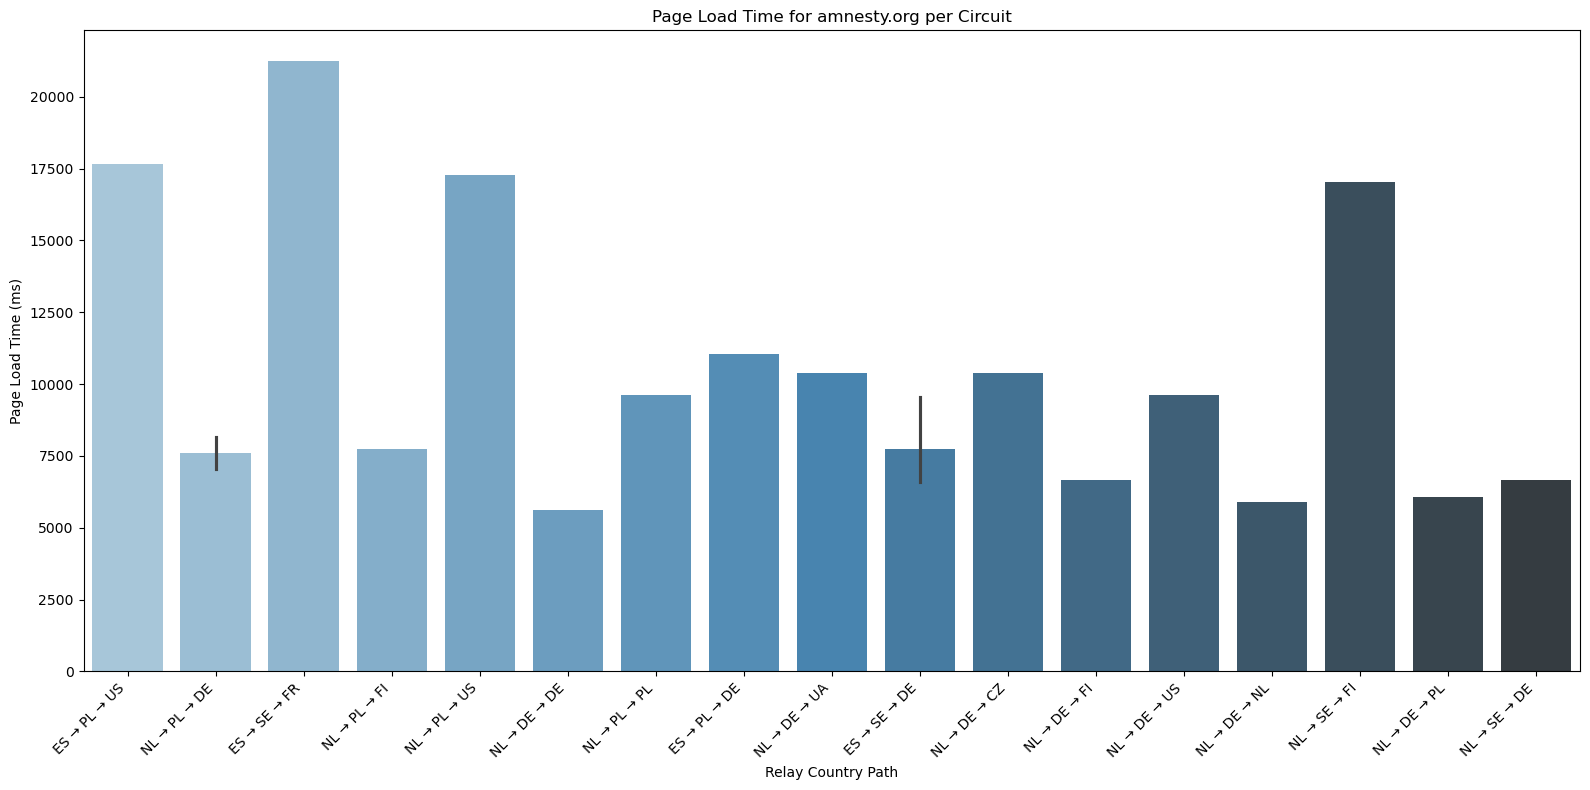

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Function to extract country codes from the relay string
def extract_country_tuple(relay_str):
    if pd.isna(relay_str):
        return ("NA",)
    countries = re.findall(r":([A-Z]{2})(?:\s|$|;)", relay_str)
    return tuple(countries)

# Filter for amnesty.org onion entries
amnesty_onion = df[(df['Clear Domain'] == 'amnesty.org') & (df['Type'] == 'onion')].copy()

# Extract relay country tuples
amnesty_onion['Relay Countries'] = amnesty_onion['Circuit Relays (Onion only)'].apply(extract_country_tuple)

# Convert tuples to string labels for plotting
amnesty_onion['Relay Country Path'] = amnesty_onion['Relay Countries'].apply(lambda x: ' → '.join(x))

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(
    data=amnesty_onion,
    x='Relay Country Path',
    y='Page Load (ms)',
    hue='Relay Country Path',
    palette='Blues_d',
    dodge=False,
    legend=False
)

plt.title('Page Load Time for amnesty.org per Circuit')
plt.xlabel('Relay Country Path')
plt.ylabel('Page Load Time (ms)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


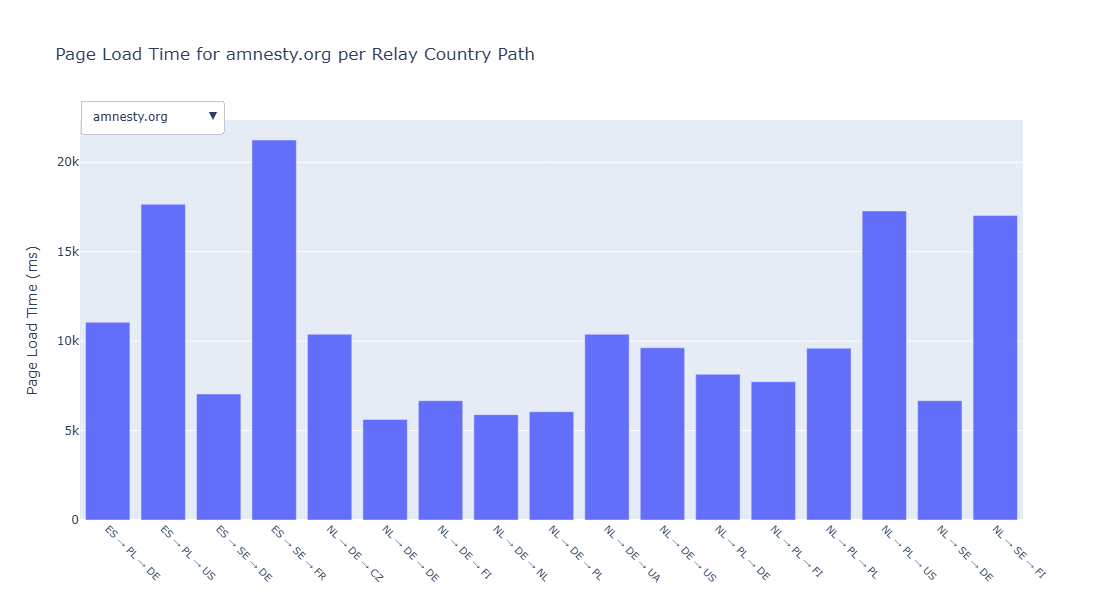

In [27]:
import pandas as pd
import plotly.graph_objects as go
import re

# Function to extract country codes from the relay string
def extract_country_tuple(relay_str):
    if pd.isna(relay_str):
        return ("NA",)
    countries = re.findall(r":([A-Z]{2})(?:\s|$|;)", relay_str)
    return tuple(countries)

# Filter for onion entries only
onion_df = df[df['Type'] == 'onion'].copy()

# Extract relay country tuples
onion_df['Relay Countries'] = onion_df['Circuit Relays (Onion only)'].apply(extract_country_tuple)

# Convert tuples to string labels for plotting
onion_df['Relay Country Path'] = onion_df['Relay Countries'].apply(lambda x: ' → '.join(x))

# Group by domain and Relay Country Path and take the first Page Load value to avoid stacking
onion_grouped = onion_df.groupby(['Clear Domain', 'Relay Country Path'], as_index=False).first()

# Get unique domains
domains = onion_grouped['Clear Domain'].unique()

# Prepare figure
fig = go.Figure()

# Add traces for each domain, showing only the first appearance of each circuit path
for i, domain in enumerate(domains):
    domain_data = onion_grouped[onion_grouped['Clear Domain'] == domain]
    
    fig.add_trace(go.Bar(
        x=domain_data['Relay Country Path'],
        y=domain_data['Page Load (ms)'],
        name=domain,
        visible=(i == 0)
    ))

# Create dropdown buttons to toggle visibility
buttons = []
for i, domain in enumerate(domains):
    visible = [False] * len(domains)
    visible[i] = True
    buttons.append(dict(
        label=domain,
        method="update",
        args=[{"visible": visible},
              {"title": f"Page Load Time for {domain} per Relay Country Path",
               "xaxis": {"title": "Relay Country Path"},
               "yaxis": {"title": "Page Load Time (ms)"}}]
    ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.0,
        y=1.05,
        xanchor='left',
        yanchor='top'
    )],
    title=f"Page Load Time for {domains[0]} per Relay Country Path",
    xaxis_tickangle=45,
    xaxis_tickfont=dict(size=10),
    yaxis_title="Page Load Time (ms)",
    height=600,
    width=900,
    margin=dict(t=120)
)

fig.show()


Looking at the plots above, we gain a clearer understanding of how the relay circuits impact page load times. As expected, the further the hops are from the source of the request (in this case, Germany), the longer the service takes to load. This correlation highlights the latency introduced by geographical distance within the tor network. However, the potential bandwidth limitations of the relays along the path, which may also contribute to slower load times, were not factored into these measurements and could be an interesting subject for future research.

### Summary



### Limitations

### Further research and direction

In [28]:
from collections import defaultdict

# Filter only onion URLs
onion_df = df[df['Type'] == 'onion'].copy()

country_counts = defaultdict(int)
relays_per_domain = defaultdict(set)
all_unique_relays = set()
all_unique_circuits = set()

for _, row in onion_df.iterrows():
    domain = row['Clear Domain']
    relays = row['Circuit Relays (Onion only)']
    if pd.isna(relays):
        continue

    relay_fingerprints = []
    for relay in relays.split(';'):
        parts = relay.strip().split(':')
        if len(parts) == 4:
            fingerprint, nickname, ip, country = parts
            # Only count known countries
            if country.lower() != 'unknown':
                country_counts[country] += 1
            relays_per_domain[domain].add(fingerprint)
            all_unique_relays.add(fingerprint)
            relay_fingerprints.append(fingerprint)

    # Each circuit is a 3-relay configuration (list of 3 fingerprints)
    if len(relay_fingerprints) == 3:
        all_unique_circuits.add(tuple(relay_fingerprints))

print("\nRelay Country Usage Summary (excluding 'Unknown'):")
for country, count in sorted(country_counts.items(), key=lambda x: -x[1]):
    print(f"{country}: {count}")

print("\nUnique Relays per .onion Domain:")
for domain, relay_set in relays_per_domain.items():
    print(f"{domain}: {len(relay_set)} unique relays")

print(f"\nTotal unique relays in dataset: {len(all_unique_relays)}")
print(f"Total unique 3-relay Tor circuits in dataset: {len(all_unique_circuits)}")



Relay Country Usage Summary (excluding 'Unknown'):
DE: 374
NL: 341
ES: 178
SE: 126
PL: 119
FR: 37
US: 33
FI: 31
GB: 17
CZ: 13
CH: 5
UA: 4
MD: 4
LV: 4
RO: 4
EE: 4
BG: 3
NO: 3
DK: 2
BE: 2
AT: 2
IT: 2
LT: 2
RU: 1
GR: 1
HU: 1
LU: 1

Unique Relays per .onion Domain:
archive.org: 26 unique relays
theguardian.com: 26 unique relays
brave.com: 26 unique relays
guardian.co.uk: 26 unique relays
voanews.com: 25 unique relays
proton.me: 26 unique relays
amnesty.org: 26 unique relays
propublica.org: 26 unique relays
archive.is: 26 unique relays
rferl.org: 26 unique relays
mullvad.net: 26 unique relays
archive.ph: 26 unique relays
mempool.space: 26 unique relays
taz.de: 22 unique relays
marxists.org: 25 unique relays
wiz.biz: 26 unique relays
f-droid.org: 26 unique relays
cock.li: 26 unique relays
mediapart.fr: 26 unique relays
riseup.net: 26 unique relays
blockstream.info: 26 unique relays
svoboda.org: 26 unique relays
torproject.org: 6 unique relays

Total unique relays in dataset: 375
Total uniqu

### References 

[1]https://spec.torproject.org/intro/index.html
[2]https://community.torproject.org/relay/types-of-relays/
[3]https://blog.torproject.org/bad-exit-relays-may-june-2020
[4]https://community.torproject.org/onion-services/overview/
[5]https://community.torproject.org/onion-services/advanced/onion-location/
[6]https://tranco-list.eu/
[7]https://www.selenium.dev/
[8]https://stem.torproject.org/index.html